# Geopolitical Research And Analysis Using The World Bank API

### Abstract:
This notebook demonstrates a dynamic use of generative models to access to World Bank data, using a human friendly interface and a free chat.
The notebook here provides a chatbot that you to ask any information from the World Bank data base, manipulate it and present it in graphs, tables or free text, according to your own choice.

Here we make a use of the Gemini models family and the Google AI-Studio.

### Usage:
A demonstration of the notebook is available here.

For a general use, run all cells and then in the last cell you should have a conversation prompt. Follow the instructions provided in the conversation and in the Markdown cell above it, and ask for whatever economical data you desire. For example:

Prompt: "Give me the GDP per capita of the USA, UK and Canada, from 2010-2020, and plot it all in a graph."

### How AI is used to make it possible?
The system uses several AI agents to process the user requests, interact with the WB database API and perform farther operations and analysis.

The first AI agent handles your request and answer it (once it gets the data). It calls behind the scenes another AI agent that translates your prompt into a structured format that matches the WB API, and yet another AI agent to fetch the data from the WB API. The agents comunicate between each other in a clever way, to make sure that your request is fulfiled as best as possible, even if you didn't provide the most accurate names (for example, you can say "The Aussie state" instead of "Australia" and the system will understand). You can also specify how you want the results to be presented to you: As a graph? a short textual summary? structured output of your choice? You name it.

In addition, per your request, farther analysis can be done, such as normalizing the results, subselection and more.

### Key functionality:
##### The notebook demonstrates the following functionalities:
* Interacting with external APIs.
* Prompt engineering.
* Few-shot prompting.
* Structured outputs.
* Context caching.
* Gen AI evaluation.
* Function calling.
* AI Agents.

### Get set up

Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

#### 1. Installations:

In [1]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
# Install the World Bank python package.
!pip install -q wbgapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.5 MB/s eta 0:00:00


#### 2. Imports:

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import wbgapi as wb

from enum import Enum
from IPython.display import Image, display, Markdown
from abc import ABC, abstractmethod
import ast

from google import genai
from google.genai import types

from typing import Union
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool

from kaggle_secrets import UserSecretsClient

genai.__version__

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


'0.8.0'

##### Automated retry:

In [38]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

#### 3. Setup macros:
Important setups and constants for the entire program.

In [3]:
# Suppress Pydantic serializer warnings:
warnings.filterwarnings("ignore", message="Pydantic serializer warnings")

# Google's AI Studio API-key:
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

# The first, welcome message to the user:
WELCOME_MSG = """Welcome to The World Bank geopolitical research tool. At any moment, type "exit", "quit" or simply "q" to quit. 
What would you like to explore today?"""

# If the user types any of these, exit the program:
QUIT_MSG_SET = {"q", "quit", "exit", "goodbye"}

# Limit the length of a single data-message that'll be stored in the message history, to prevent overuse of tokens:
MSG_LEN_LIMIT = 10000

# The maximal number of re-calls to ask the WB-agents to fetch data, after checking its validity failed. 0 = No re-calls (fetching and checking once, but no re-attempts).
MAX_CHECK_RETURNED_DATA_RECALLS = 2

# Roles for the google.genai gemini models:
user_role = "user"
model_role = "model"
system_role = "system"

### AI Model setup:

Here we define the Gemini models. 

The models will be used by the different agents to interact with the user, with the WB data API and to invoke function callng.

##### Function tools declarations for the various models: #####
In the next cells we'll declare and implement the function tools that will be used by the AI models. After that, we'll define the models themselves.

The following functions are for the user-interface model

In [4]:
# Tool functions for plotting graphs:

plot_single_curve_graph_declaration = types.Tool(
    function_declarations=[
        {
            "name": "plot_single_curve_graph",
            "description": "Plot a single y(x) curve graph in a single figure.",
            "parameters": {
                "type": "object",
                "properties": {
                    "y": {
                        "type": "array",
                        "description": "A list of the y-values of the data points.",
                        "items": {"type": "number"}
                    },
                    "x": {
                        "type": "array",
                        "description": "A list of the x-values of the data points.",
                        "items": {"type": "number"}
                    },
                    "title": {
                        "type": "string",
                        "description": "A short title for the graph."
                    },
                    "xlabel": {
                        "type": "string",
                        "description": "A label in the format \"name [units]\" for the x-axis."
                    },
                    "ylabel": {
                        "type": "string",
                        "description": "A label in the format \"name [units]\" for the y-axis."
                    }
                },
                "required": ["y", "x", "title", "xlabel", "ylabel"]
            },
        }
    ]
)

# Plot a single curve on a single graph (figure):
def plot_single_curve_graph(y: list[float], x: list[float], title: str, xlabel: str, ylabel: str):
    '''
    Plot a single y(x) curve graph in a single figure.
    
    Arguments:
        y (list[float]): A list of the y-values of the data points.
        x (list[int]): A list of the x-values of the data points.
        title (str): A short title for the graph.
        xlabel (str): A label in the format "name [units]" for the x-axis.
        ylabel (str): A label in the format "name [units]" for the y-axis.
    '''

    fig = plt.figure()
    plt.plot(x, y, '*-')
    rot_ang = 90 if len(x) > 30 else 45 if len(x) > 10 else 0
    plt.xticks(x, rotation=rot_ang, ha='right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_multi_curve_graph_declaration = types.Tool(
    function_declarations=[
        {
            "name": "plot_multi_curve_graph",
            "description": "Plot a graph of several y(x) curves in the same figure, of the given data (y1(x), y2(x), ...).",
            "parameters": {
                "type": "object",
                "properties": {
                    "y": {
                        "type": "array",
                        "description": "A list of separated serieses of data points (i.e. y1=[y1_1, y1_2, y1_3, ...], y2=[y2_1, y2_2, y2_3, ...], ...).\n" + \
                            "Example: y=[y1, y2] where y1=[...] is a list of USA's GDP values, and y2=[...] is a list of UK's GDP values.",
                        "items": {"type": "array", "items": {"type": "number"}}
                    },
                    "x": {
                        "type": "array",
                        "description": "A list of values for the x axis. Example: a set of years.",
                        "items": {"type": "number"}
                    },
                    "title": {
                        "type": "string",
                        "description": "A short title for the graph."
                    },
                    "xlabel": {
                        "type": "string",
                        "description": "A label in the format \"name [units]\" for the x-axis."
                    },
                    "ylabel": {
                        "type": "string",
                        "description": "A label in the format \"name [units]\" for the y-axis."
                    },
                    "leged_labels": {
                        "type": "array",
                        "description": "A very short label-name for each curve. If leged_labels is None (its default value) then the labels will " +\
                            "be set to be the indices of the curves (1 for y1, 2 for y2 and so on). \n" +\
                            "Example: If y1 is Norway's population and y2 is China's army size, then leged_labels=[\"Norway pop.\", \"Chinese army\"]",
                        "items": {"type": "string"},
                        "nullable": "True"
                    }
                },
                "required": ["y", "x", "title", "xlabel", "ylabel"]
            },
        }
    ]
)


# Plot multiple curves on a single graph (figure):
def plot_multi_curve_graph(y: list[list[float]], x: list[float], title: str, xlabel: str, ylabel: str, leged_labels: Union[list[str], None] = None):
    '''
    Plot a graph of several y(x) curves in the same figure, of the given data (y1(x), y2(x), ...).
    
    Arguments:
        y (list[list[float]]): A list of separated serieses of data points (i.e. y1=[y1_1, y1_2, y1_3, ...], y2=[y2_1, y2_2, y2_3, ...], ...). 
                Example: y=[y1, y2] where y1=[...] is a list of USA's GDP values, and y2=[...] is a list of UK's GDP values.
        x (list[float]): A list of values for the x axis. Example: a set of years.
        title (str): A short title for the graph.
        xlabel (str): A label in the format "name [units]" for the x-axis.
        ylabel (str): A label in the format "name [units]" for the y-axis.
        leged_labels (list[str]): A very short label-name for each curve. If leged_labels is None (its default value) then the labels will 
                be set to be the indices of the curves (1 for y1, 2 for y2 and so on). 
                Example: If y1 is Norway's population and y2 is China's army size, then leged_labels=["Norway pop.", "Chinese army"]
    '''
    fig = plt.figure()
    for i in range(len(y)):
        plt.plot(x, y[i], '*-', label=(leged_labels[i] if leged_labels is not None else str(i)))
        
    rot_ang = 90 if len(x) > 30 else 45 if len(x) > 10 else 0
    plt.xticks(x, rotation=rot_ang, ha='right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_single_bars_graph_declaration = types.Tool(
    function_declarations=[
        {
            "name": "plot_single_bars_graph",
            "description": "Plot a single bar-graph in a single figure.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data_series": {
                        "type": "array",
                        "description": "A list of the data points values.",
                        "items": {"type": "number"}
                    },
                    "title": {
                        "type": "string",
                        "description": "A short title for the graph."
                    },
                    "xlabel": {
                        "type": "string",
                        "description": "A general name for the x-axis (e.g. \"Countries\")."
                    },
                    "ylabel": {
                        "type": "string",
                        "description": "A label in the format \"name [units]\" for the y-axis."
                    },
                    "data_labels": {
                        "type": "array",
                        "description": "A list of very short label-names for each bar (data point) (e.g [\"Congo\", \"Brazil\"]). " +\
                            "If data_labels is None (its default value) then the labels will be set to be the indices of the bars (['1', '2', ...]).",
                        "items": {"type": "string"}
                    }
                },
                "required": ["data_series", "title", "xlabel", "ylabel"]
            },
        }
    ]
)


def plot_single_bars_graph(data_series: list[float], title: str, xlabel: str, ylabel: str, data_labels: Union[list[str], None] = None):
    '''
    Plot a single bar-graph in a single figure.

    Arguments:
        data_series (list[float]): A list of the data points values.
        title (str): A short title for the graph.
        xlabel (str): A general name for the x-axis (e.g. "Countries").
        ylabel (str): A label in the format "name [units]" for the y-axis.
        data_labels (list[str]): A list of very short label-names for each bar (data point) (e.g ["Congo", "Brazil"]).
                If data_labels is None (its default value) then the labels will be set to be the indices of the bars (['1', '2', ...]).
    '''
    
    # Width of each bar:
    series_len = len(data_series)
    bar_width = 1 / (series_len + 2)

    # Make the x and y values for the graph:
    x_pos = [(i + 0.5 * bar_width) for i in range(series_len)]  # The starting coordinate of each bar
    y_vals = [(val if val is not None else 0) for val in data_series]

    # Create a figure:
    fig = plt.figure()

    # Generate colors (using a colormap)
    cmap_name = 'tab10' if series_len <= 10 else 'tab20'
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i % cmap.N) for i in range(series_len)]
    
    plt.bar(x_pos, y_vals, width=bar_width, color=colors, edgecolor='black')
    plt.title(title)

    # Set the labels:
    xticks_vals = x_pos
    xticks_labels = data_labels if data_labels else [str(i + 1) for i in range(series_len)]
    rot_ang = 45
    plt.xticks(xticks_vals, xticks_labels, rotation=rot_ang, ha='right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_multi_bars_graph_declaration = types.Tool(
    function_declarations=[
        {
            "name": "plot_multi_bars_graph",
            "description": "Plot a bar graph for several categories, where each category has several bars. All in the same figure. The plot will show groups of " +\
                "several bars, where each group is a separated category and the bars in each group are the series data points relevant to the category.\n" +\
                "Examples: \n" +\
                "1) Plot a bar graph of the population in several years of the UK, France and Germany. Each country is a \"category\"" +\
                "and for each one there are several data points (bars) that show the population in each year. \n" +\
                "2) Plot a bar graph of the birth rate, baby mortality rate and total mortality rate of Australia in several years. Here " +\
                "each indicator (birth/death rate type) is a \"category\" and for each one there are several data points (bars) that show " +\
                "the respective budget value in each year.",
            "parameters": {
                "type": "object",
                "properties": {
                    "data_series_by_category": {
                        "type": "object",
                        "description": "A dictionary where the keys are the category names (e.g. countries) and the values " +\
                            "are lists of data points (e.g. population in different years). Missing data points should be marked as 0 or None."
                    },
                    "title": {
                        "type": "string",
                        "description": "A short title for the graph."
                    },
                    "xlabel": {
                        "type": "string",
                        "description": "A general name for the x-axis (e.g. \"Countries\" for the example above)."
                    },
                    "ylabel": {
                        "type": "string",
                        "description": "A label in the format \"name [units]\" for the y-axis."
                    },
                    "leged_labels": {
                        "type": "array",
                        "description": "A list of very short label-names for each bar (data point) in a category (e.g [\"year 1\", \"year 2\"] for the example above). " +\
                            "If leged_labels is None (its default value) then the labels will be set to be the indices of the bars (for the example above: 1 for " +\
                            "the first year, 2 for the second year and so on).",
                        "items": {"type": "string"},
                        "nullable": "True"
                    }
                },
                "required": ["data_series_by_category", "title", "xlabel", "ylabel"]
            },
        }
    ]
)


def plot_multi_bars_graph(data_series_by_category: dict[str, list[float]], title: str, xlabel: str, ylabel: str, leged_labels: Union[list[str], None] = None):
    '''
    Plot a bar graph for several categories, where each category has several bars. All in the same figure. The plot will show groups of 
    several bars, where each group is a separated category and the bars in each group are the series data points relevant to the category.
    Example: Plot a bar graph of the population in several years of the UK, France and Germany. Each country is a "category" 
        and for each one there are several data points (bars) that show the population in each year.
    
    Arguments:
        data_series_by_category (dict[str, list[float]]): A dictionary where the keys are the category names (e.g. countries) and the values 
                are lists of data points (e.g. population in different years). Missing data points should be marked as 0 or None.
        title (str): A short title for the graph.
        xlabel (str): A general name for the x-axis (e.g. "Countries" for the example above).
        ylabel (str): A label in the format "name [units]" for the y-axis.
        leged_labels (list[str]): A list of very short label-names for each bar (data point) in a category (e.g ["year 1", "year 2"] for the example above).
                If leged_labels is None (its default value) then the labels will be set to be the indices of the bars (for the example above: 1 for 
                the first year, 2 for the second year and so on).
    '''

    # Extract the category names and a series of data lists:
    # serieses = data_series_lists
    categories = data_series_by_category.keys()
    serieses = data_series_by_category.values()
    
    # The highest number of data points in a category:
    series_max_len = max([len(series) for series in serieses])
    # Convert to a 2D numpy array, with 0-padding if needed:
    serieses_arr = np.array([[(val if val is not None else 0) for val in series] + [0]*(series_max_len - len(series)) for series in serieses])
    
    # Width of each bar:
    bar_width = 1 / (series_max_len + 2)
    
    # Create a figure and axis:
    fig, ax = plt.subplots()
    
    # Plot bars of each data point (year) across all the categories, with some spacing:
    for i in range(series_max_len):
        x_pos = [(pos + i * bar_width) for pos in range(len(categories))]  # The starting coordinate of each bar i, across all the categories (serieses).
        ax.bar(x_pos, serieses_arr[:, i], width=bar_width, edgecolor='black')

    # Set x-axis labels:
    ax.set_xticks([(pos + 0.5 * bar_width * (series_max_len - 1)) for pos in range(len(categories))])
    rot_ang = 45
    ax.set_xticklabels(categories, rotation=rot_ang, ha='right')
    ax.set_xlabel(xlabel)
    
    # Set y-axis label
    ax.set_ylabel(ylabel)
    
    # Add a legend for the values
    leged_labels = leged_labels if leged_labels else [str(i + 1) for i in range(series_max_len)]
    ax.legend(leged_labels)
    
    # Set the title
    plt.title(title)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


plotting_tool_funcs = [plot_single_curve_graph_declaration, plot_multi_curve_graph_declaration, plot_single_bars_graph_declaration, plot_multi_bars_graph_declaration]
plotting_tool_funcs_select = {
    "plot_single_curve_graph": plot_single_curve_graph,
    "plot_multi_curve_graph": plot_multi_curve_graph,
    "plot_single_bars_graph": plot_single_bars_graph,
    "plot_multi_bars_graph": plot_multi_bars_graph
}


In [5]:
# List of tools (functions that can be called) for the user-interface model:

extract_query_tool_funcs = [
    # This function extract a query request from the user, to fetch data from the WB:
    types.Tool(
        function_declarations=[
            types.FunctionDeclaration(
                name="extract_general_request_components",
                description="Use this function if the user asks for information from the World Bank. " +\
                "Extract relevant countries, indicators, years, farther analysis or operations (to do on the results) and desired output format, from a user request.",# +\
                # "The parameter Apply_on_last_returned_results indicates if the user wants the analysis to be done on data that was already returned previously.",
                parameters={
                    "type": "object",
                    "properties": {
                        "countries": {"type": "array", "items": {"type": "string"}},
                        "indicators": {"type": "array", "items": {"type": "string"}},
                        "years": {"type": "array", "items": {"type": "integer"}},
                        "analysis": {"type": "array", "items": {"type": "string"}},
                        "output_format": {"type": "string"},
                    },
                    "required": ["countries", "indicators", "years"]
                }
            )
        ]
    ),
    
    # This function extract a query request from the user, to translate known names with WB codes:
    types.Tool(
        function_declarations=[
            types.FunctionDeclaration(
                name="extract_request_for_names_translation",
                description="The user only wants to translate names of countries or economical indicators to the World Bank codes " +\
                "(or the other way around). Use this function to extract relevant countries and indicators names, farther analysis and desired " +\
                "output format from a user prompt.",
                parameters={
                    "type": "object",
                    "properties": {
                        "countries": {"type": "array", "items": {"type": "string"}},
                        "indicators": {"type": "array", "items": {"type": "string"}},
                        "analysis": {"type": "array", "items": {"type": "string"}},
                        "output_format": {"type": "string"}
                    },
                    "required": ["countries", "indicators"]
                }
            )
        ]
    ),

    # This function extract a query request from the user, to apply (additional?) analysis on data that was already fetched and returned to the user:
    types.Tool(
        function_declarations=[
            types.FunctionDeclaration(
                name="extract_request_for_operations_on_previous_data",
                description="Use this function if the user asks for a different output formats, farther analysis or other operations to be done " +\
                    "on data that was already returned to the user previously. The function performs the requested tasks and presents " +\
                    "the updated results to the user, according to its output format.\n Arguments:" +\
                    "\"analysis\": A list of the requested analysis operations over the data, such as normalizing, factorizing, taking only top " +\
                        "10 data etc. \n" +\
                    f"\"data_struct\": A dictionary of the data on which the analysis should be applied. Use the original data structure from the \"{system_role}\" prompts." +\
                    "\"output_format\": A string of the output format, according to the user's last relevant instructions. Examples: Plot a " +\
                        "graph, table, summarize the data in a particular way",
                parameters={
                    "type": "object",
                    "properties": {
                        "analysis": {"type": "array", "items": {"type": "string"}, "description": "Instructions of operations and manipulations " +\
                                     "to be done on the data. Don't confuse with output-format-instructions."},
                        "data_struct": {"type": "object", "description": "The data the user wants the analysis/outputting to apply to. A dictionary."},
                        "output_format": {"type": "string", "description": "Instructions of how to present the data to the user (such as graph, " +\
                                          "table, textual with specifications etc."}
                    },
                    "required": ["analysis", "data_struct"]
                }
            )
        ]
    ),
]

extract_query_tool_funcs_select = {"extract_general_request_components": None,
                                   "extract_request_for_names_translation": None,
                                  "extract_request_for_operations_on_previous_data": None}

The following functions are for the analysis model.

In [6]:
# Tool functions for data analysis:

def normalize_data_list_by_norm_value(data_lst: list[float], norm: float) -> list[float]:
    '''
    Normalize (divide) all the given data list by the given single norm value, (meaning 
    result[i] = data[i] / norm for each i), and return the result. For example: 
        data_lst = list of the budget per year, 
        norm = the budget at a specific, reference year, 
        Return: A list of the budget percentage at each year, relative to the reference value.
    
    Arguments:
        data_lst (list[float]): A list of data values. Example: A country's budget of each year.
        norm (float): The normalization value. Example: The country's budget at a specific, reference year.

    Raise:
        An exception with an error message, if norm = 0.
    '''
    
    if norm == 0:
        raise Exception("Error: Cannot divide by 0!")
    return [val / norm for val in data_lst]


def factorize_data_list_by_factor_value(data_lst: list[float], factor: float) -> list[float]:
    '''
    Factorize (multiply) all the given data list by the given single factor value, (meaning 
    result[i] = data[i] * factor for each i), and return the result. For example: 
        data_lst = list of commodity prices in one currency, 
        factor = the exchange rate to another currency, 
        Return: A list of the commodity prices in the other currency
    
    Arguments:
        data_lst (list[float]): A list of data values. Example: commodity prices in one currency.
        factor (float): The value to multiply. Example: The exchange rate to another currency.
    '''
    
    return [val * factor for val in data_lst]


def normalize_data_list_by_norm_list(data: list[float], norm: list[float]) -> list[float]:
    '''
    Normalize (divide) the given data list by the given norm list, point by point (meaning 
    result[i] = data[i] / norm[i] for each i), and return the result. For example: 
        data = list of the budget per year, 
        norm = list of the population at each year, 
        Return: A list of the budget-per-person at each year.
    * If at some index i norm[i] == 0 then the result's value at that index will be None.
    
    Arguments:
        data (list[float]): A list of data values. Example: A country's budget of each year.
        norm (list[float]): A list of the normalization values. Example: The country's population each year.

    Raise:
        An exception with an error message, if the lengths of the 2 lists are not equal.
    '''
    
    if len(data) != len(norm):
        raise Exception("Error: The 2 given lists must have the same lengths!")
    return [((data[i] / norm[i]) if norm[i] != 0 else None) for i in range(len(data))]


def factorize_data_list_by_factor_list(data: list[float], factors: list[float]) -> list[float]:
    '''
    Factorize (multiply) the given data list by the given factors list, point by point (meaning 
    result[i] = data[i] * factors[i] for each i), and return the result. For example: 
        data = list of the nominal GDP ($) per year, 
        factors = list of the GDP growth rate (%) at each year, 
        Return: A list of the GDP changed ($) at each year.
    
    Arguments:
        data (list[float]): A list of data values. Example: A country's nominal GDP at each year.
        factors (list[float]): A list of the factor values. Example: The country's GDP growth rate each year.

    Raise:
        An exception with an error message, if the lengths of the 2 lists are not equal.
    '''
    
    if len(data) != len(factors):
        raise Exception("Error: The 2 given lists must have the same lengths!")
    return [data[i] * factors[i] for i in range(len(data))]


analysis_tool_funcs = [normalize_data_list_by_norm_value, factorize_data_list_by_factor_value, normalize_data_list_by_norm_list, factorize_data_list_by_factor_list]

##### User-interface model for the user-interface agent: #####

In [29]:
# Instructions for the conversation model for the user-interface agent:
user_model_system_instruction = """You're a system that fetches and analyze geopolitical data from the \"World Bank\" database, 
according to user's requests.
You will help the user, chat with them and answer their questions. Beside chatting, the user may also make requests for the following:
1. Get Economical information from the world bank. It may or may not include instructions for farther operations, analysis and ploting.
    It should include:
    * Details for the World Bank such as countries (e.g. Italy, the OECD, ...), indicators (e.g. population, GDP, ...) and time range 
        in years (if the user didn't specify time, set the previous year by default).
    * May contain instructions for additional analysis and operations on the results, such as normalizing the results by a factor or 
        another indicator (and if relevant, add this indicator to the indicators list if it's not there already).
    * May contain instructions for how the data results should be plotted/presented to the user (table, graph, other structure, various 
        text formats, summary or whatever the user specifies). If the user didn't specify, assume "table" by default.
2. Get information about the World Bank, such as what are its codes for known country names, or to translate codes into meaningful labels, 
    and so on.
3. Perform operations and analysis on data that was previousely sent to the user.
4. Plot in various formats the data that was previousely sent to the user.

Once the user makes a request, you should take the requests and turn them into queries using the tools available. The queries will be used 
by other AI-agents in the system that will answer them. You can and should use the tools available for you, but before that make sure you 
got from the user all the information needed according to the tools descriptions. If you don't have all the information, try to figure it 
out from the conversation and available data, and if you can't then ask the user for the missing information (for example, label units for 
graphs you can usually figure out from the data returned. But if the user didn't specified the countries and it's not clear from the previous 
message, ask them).
Relevant function tools include, but not limited to: 
    * "extract_general_request_components" - Get information from the World Bank.
    * "extract_request_for_names_translation" - Translate between names and World Bank's codes (both directions).
    * "extract_request_for_operations_on_previous_data" - Perform operations, analysis or ploting of data that was already sent to the user. 
        Make sure not to confuse between the \"analysis\" and \"output_format\" arguments.
    * There might be more function tools...

Once you get from the other agents the information, you might be instructed to check if it answers the user's request and if not refine the query. 
If you get such instructons, follow them.
Once you get from the other agents the right results with everything you need, you will answer the user's question using the data returned and the user's instructions, 
such as about the output format.

Notes:
- The user makes the requests in free text and another AI-agent will later translates the relevant terms into the World Bank's codes (not 
    your responsibility).
- If the user asks for things like "OECD poplation" then the country in the query is the "OECD" and the indicator is "population". But if 
    the user asks for "top 11 OECD members in terms of population" then the countries are "all OECD members", the indicator is still "population" and the 
    analysis instructions say to take 11 highest countries by population.
- If the user's query is missing important data, you should ask for additional questions. 
- Once you have all the information you need, use the provided function tools to extract the query into a structured data.
- If you call some functions that require labels to plot the results, give them short but meaningful labels, and not codes.
- Unless the user asked for it explicitly, do not show results or plots to the user with the World Bank codes. You should find meaningful names 
    from the data you already have and use them.
- Always keep and show the units of each indicator. Exceptions are allowed for unit-less indicators such as "population, total".

Example:
The user asks: "Plot a curve of the percentage of income held by the wealthiest 10%, of the top 5 OECD by GDP per capita PPP (last year), 
    in the years 2010-2022."
You should call the function "extract_general_request_components" with these arguments (or something similar):
    args = {"countries": ["all OECD members"], 
            "indicators": ["percentage of richest 10% income", "GDP per capita PPP"], 
            "years": [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
            "analysis": ["select 5 countries with highest GDP per capita PPP value in 2023"], 
            "output_format": "multi line graph"}
"""

tool_spec_user_agent = extract_query_tool_funcs + plotting_tool_funcs
tool_spec_user_agent_select = extract_query_tool_funcs_select | plotting_tool_funcs_select

# User-interface model configurations.
client = genai.Client(api_key=GOOGLE_API_KEY)
user_agent_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=0.1,
    system_instruction=user_model_system_instruction,
    tools=tool_spec_user_agent
)


# The user-conversation model for the user-interface agent. Gets the prompt as input.
def user_agent_model(prompt: str):
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
        config=user_agent_config,
    )
    return response

##### General purpose model for free text: #####

In [8]:
# Instructions for the translation model for the translate-wb agent:
translate_model_system_instructions = """You're a search engine of the World Bank API.
Given the following list of items from the World Bank, and a user query, find the item that matches best 
with the query, and return its index (0-based), and no other words. If you can't find any, return -1. 
If the user explicitly asks for several items, such as "all OECD members" or "all countries" (or something 
at the sort), then retuen a list of the indices, space separated (example: "2 13 44 45"), of all the OECD members or 
all the countries (without organizations), respectively.

Hints:
1. Usually when the user say \"population\" they mean the total population.
2. Do not confuse between cases like "OECD" (a single item) and "all OECD members" (several items separately).
"""

# General purpose free text model. Gets the instructions and content as inputs.
def generate_free_text_model(instructions: str, content: str):
    response =  client.models.generate_content(
        model="gemini-2.0-flash",
        contents=content,
        config=types.GenerateContentConfig(
            system_instruction=instructions
        ),
    )
    return response

##### Analysis model for the data-handler agent: #####

In [9]:
# Instructions for the data-handler agent's analysis model:
analysis_model_system_instructions = """You're a data expert that can perform analysis on data from the World Bank.
Given a data fetched from the World Bank API (usually as a Pandas DataFrame formatted as a dictionary), and 
a list of instructions  for manipulating and analyzing the data, you should first look for available tools (function calls) 
that can do it and then use them. If there are none such tools you can try to complete the instructions by yourown. 
If you can't, give a short error message that indicates the failure.

* You must return the results in the same format like you got it. Meaning, if you got it as a DataFrame 
    formatted as a Python dictionary, you must return a DataFrame formatted strictly as a Python dictionary as well.
* Do not include any explanations, text, or extra formatting.
* Update the names/labels, title and units to accordingly. For example: If you multiply "GDP per capita (units...)" with the 
"population", update it to "GDP (units...)". If you normalize "Military expenditure (current US$)" by the populatio, update 
    it to "Military expenditure per capita (current US$)".
"""

# The analysis model that performs farther analysis on the data fetched from the WB, using function calling.
def analysis_model(prompt: str):
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
        config=types.GenerateContentConfig(
            system_instruction=analysis_model_system_instructions,
            temperature=0,
            top_p=0,
            tools=analysis_tool_funcs,
        ),
    )
    return response

## Agents and LangGraph setup:

Here we build the AI agents and define the graph and state classes they'll work on.

The AI agents work with the LangGraph interface package, which uses a graph-state object to follow the evolution of the graph. Each "node" in the graph works on and modifies the state.

### 1. Define the graph's State class.

The state should have a "status" field that helps directing the state flow through the graph, and other fields that contain relevant information about the conversation and the ata from the WB.

In [31]:
# All the possible State's statuses.
class StatusEnum(Enum):
    """An enum for the State's status field."""
    
    new_conversation = "new_conversation"  # The first conversation, Start with WELCOME_MSG (to the user).
    continue_conversation = "continue_conversation"  # Continue the session, in which the user may ask to refer to data/messages from the previous ones.
    
    request_data = "request_data"  # The user specified what data they want from the world bank.
    request_analysis = "request_analysis"  # The user may specify farther analysis for previous data, such as normalizations or graphs.
    request_wb_codes = "request_wb_codes" # The user wants to know what are the World Bank codes for the given countries and/or indicators.

    data_ready = "data_ready"  # The data was fetched and ready to be sent to the user.
    
    no_code_match = "no_code_match"  # Some of the user's countries/indicators/etc don't match any of the World Bank codes.
    fetch_failed = "fetch_failed"  # For some reason we couldn't fetch the data.
    session_end = "session_end"  # the user quits the conversation.


# This class represents the type of "requested_data_struct" field in "GeoDataState" state class.
class RequestedDataStruct(TypedDict):
    '''This is the structure of the "requested_data_struct" field, that should hold the necessary 
    parameters to make a query to the WB data API'''
    
    countries: list[str]
    indicators: list[str]
    years: list[int]
# Default values for RequestedDataStruct:
default_data_struct = {"countries": [], "indicators": [], "years": []}


# The main Graph state class.
class GeoDataState(TypedDict):
    """State representing the user's request for geo-political information, and the data."""
    
    history: list[str]                      # Context history.
    status: StatusEnum                      # The status. Indicates which agent should work and what opperation it should do.
    requested_data_struct: RequestedDataStruct  # Holds the necessary parameters to make a query to the WB.
    requested_analysis: list[str]           # Instructions for farther analysis on the resulted fetched data.
    output_format: str                      # Text? Table? Graphs? Specific summary? Tell the model.
    data_results_struct: Union[pd.DataFrame, dict]   # The results of the user's query. To be outputed to the user
    errors: Union[str, list[str]]           # Errors made in the query.
    check_returned_data_loop_count: int     # A counter for returned data checks for a request:
# Default, initial state:
default_state = {"history": [], "status": StatusEnum.new_conversation, 
                 "requested_data_struct": default_data_struct, "requested_analysis": [], 
                 "output_format": "", "data_results_struct": pd.DataFrame(), "errors": "", "check_returned_data_loop_count": 0}

### 2. Define the AI agent classes.

Each agent is responsible for another part of the system:
* user_agent (UserInterfaceAgent) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; : Handles the user interactions.
* translate_agent (TranslateWBCodesAgent) &nbsp; : Handles name-code translations
* data_agent (DataHandlerAgent) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; : Handles the data retreival and farther analysis

In [32]:

class WBAgent(ABC):
    """
    This is an abstract class of an AI agent for the World Bank (WB) reseach system. It's used in the LangGraph architecture.
    Other agent classes must inherit and implement it.
    Attributes:
        state: GeoDataState
            The state of the graph the agents work in.
    Methods:
        run() -> GeoDataState
            This method invokes the agent's run on the state, and returns it.
    """
    
    def __init__(self, state: GeoDataState):
        """
        A constructor. Creates a new agent instance (depends on the implementing class).
        Parameters:
            state: GeoDataState
                A state that the agent runs on. Part of the LangGraph flow.
        """
        self.state = state

    
    @abstractmethod
    def run(self) -> GeoDataState:
        """
        The main run of the agent. To be implemented by other classes.
        Parameters:
            None
        Returns:
            The updated GeoDataState state object, after the run.
        """
        pass


    # A helper function to flatten list of potential lists.
    def _flatten(self, list_of_lists: list) -> list:
        result = []
        for lst_or_n in list_of_lists:
            if type(lst_or_n) is list:
                result.extend(lst_or_n)
            else:
                result.append(lst_or_n)
        return result


class UserInterfaceAgent(WBAgent):
    """
    This class implements an AI agent that handles the user interactions for the World Bank (WB) reseach system. 
    It's used in the LangGraph architecture.
    
    * Use a gemini model to handle the conversations with the user and always append it to the state's history field 
        (the messages).
    * If the status is new_conversation: start the conversation with WELCOME_MSG (append to history).
        * If the user typed quit: update the status to session_end and return the state.
        * Optional: Make a conversation and move to the next agent only when a clear, structured request was made.
        * Get a request from the user, append it to the state's message history, structure it (with a different 
            model? the same one?) to the data they ask, the analysis and output format, add it to the state's 
            requested_data_struct, requested_analysis and output_format fields, update the state's status to request_data 
            and return the updated state.
    * If the state's status is data_ready: send the data to the user (structured or unstructured, or graph-plots, 
        according to state's output_format), append the response to the state's message history, update the status 
        to continue_conversation and return the state.
    * If the state's status is no_code_match: check the state's errors field, ask the user to refine the request by 
        it, append and update to the state, update the state's status to request_data and return the updated state.
    * If the state's status is fetch_failed: Tell the user the operation failed, update the status to continue_conversation 
        and return the state.
    * If the status is continue_conversation: continue the conversation for a new request.
        * If the user typed quit: update the status to session_end and return the state.
        * Get a request from the user and append it to the state's history.
            * If it's an analysis request (llm decides) for the previous data: add it to the state's analysis field, update 
                the state's status to request_analysis and return the updated state.
            * If it's a new data request (llm decides): structure it with a new llm, add it to the state (override previous), 
                update the state's status to request_data and return the updated state.
    """

    def __init__(self, state: GeoDataState):
        """
        A constructor. Creates a new UserInterfaceAgent instance.
        Parameters:
            state: GeoDataState
                A state that the agent runs on. Part of the LangGraph flow.
        """
        super().__init__(state)


    # A helper function to append a message to the history.
    def _append(self, msg, role):
        # self.state["history"].append({"role": role, "content": msg})  # OpenAI convention.
        self.state["history"].append((role, msg))  # Google convention.

    
    # A helper function that both print to the user and append a message to the history.
    def _print_and_append(self, msg, role=model_role):
        display(Markdown(msg))
        self._append(msg[:MSG_LEN_LIMIT], role)


    # This function wraps the call of a model function and returns the text and function_call response.
    def _invoke_AI_model(self, prompt: tuple[str]):
        try:
            if prompt:
                response = user_agent_model(self.state["history"] + [prompt])
            else:
                # prompt was already appended into history:
                response = user_agent_model(self.state["history"])
    
        except Exception as e:
            raise Exception("We got an internal error:  \n" + str(e))
        
        # Extract the user's request that later will be added into the state object:
        return response.candidates[0].content.parts
    

    # A helper function that tries to convert a given data structure into Pandas DataFtame.
    def _convert_to_table(self, data):
        if type(data) != pd.DataFrame:
            try:
                data = pd.DataFrame(data)
            except:
                pass
        return data


    # A helper function to output the results to the user as a text:
    def _output_results(self, results: Union[pd.DataFrame, dict]):
        # Check for errors that didn't block the data retrieval:
        if self.state["errors"]:
            self._print_and_append("We've encountered an error:\n" + str(self.state["errors"]))
            self.state["errors"] = []
        
        output_format = self.state.get("output_format", "free text")

        # The user requests a table -> display a Pandas DataFrame.
        if output_format == "table":
            results = self._convert_to_table(results)
            display(results)
            self._append(str(results), model_role)

        # Any other format -> Let the AI model handle it.
        else:
            content = (system_role, "Answer the user with the following data bellow, which was returned from another agent. " + \
            f"Present the data in the following format:  \n {output_format}  \n" +\
            "Don't write an opening line nor confirmation line.  \nThe data:  \n" + str(results))
            
            try:
                response_parts = self._invoke_AI_model(content)
                for part in response_parts:
                    response_text, response_fn_call, response_fn_response = part.text, part.function_call, part.function_response
                    # The model responded with just a text:
                    if response_text:
                        self._print_and_append(response_text)
                    # The model responded with a suggestion for a function call:
                    if response_fn_call and response_fn_call.name in tool_spec_user_agent_select:
                        func = tool_spec_user_agent_select[response_fn_call.name]
                        func_results = func(**response_fn_call.args)
                        if func_results:
                            # For now we don't have such functions so we cannot say how to generally deal with their outputs.
                            pass
                            
            except Exception as e:
                # An error in the AI model: Print the message to the user and append it to the history.
                self._print_and_append(str(e))

    
    # A helper function that asks the user for their request and return its arguments.
    def _get_user_request(self, msg: str=""):
        if msg:
            self._print_and_append(msg)

        user_input = input("\n>: ")
        
        # Check if the user wishes to exit:
        if user_input.strip().lower() in QUIT_MSG_SET:
            self.state["status"] = StatusEnum.session_end
            return None, None

        # Get the user's request:
        try:
            part = self._invoke_AI_model(("user", user_input))[0]
            self._append(user_input, user_role)
            response_text, response_fn_call = part.text, part.function_call
        except Exception as e:
            response_text = str(e)
            response_fn_call = None
    
        return response_text, response_fn_call


    # A helper function that updates the state in the case of a general purpose request.
    def _update_state_for_general_request(self, args: dict):
        self.state["requested_data_struct"] = {
            "countries": args.get("countries", []),
            "indicators": args.get("indicators", []),
            "years": args.get("years", [])
        }
        
        self.state["requested_analysis"] = args.get("analysis", [])
        self.state["output_format"] = args.get("output_format", "text")
        self.state["status"] = StatusEnum.request_data
        return self.state["status"]


    # A helper function that updates the state in the case of specific request to translate between normal names and WB codes.
    def _update_state_for_names_translation_request(self, args: dict):
        self.state["requested_data_struct"] = {
            "countries": args.get("countries", []),
            "indicators": args.get("indicators", []),
            "years": args.get("years", [])
        }

        self.state["requested_analysis"] = args.get("analysis", [])
        self.state["output_format"] = args.get("output_format", "text")
        self.state["status"] = StatusEnum.request_wb_codes
        return self.state["status"]


    # A helper function that updates the state in the case that the user asks to perform more analysis on previous data that was already returned.
    def _update_state_for_analysis_on_prev_results(self, args: dict):
        # The user asked to apply farther analysis on the last results:
        self.state["requested_analysis"] = args.get("analysis", [])
        self.state["output_format"] = args.get("output_format", "text")

        if not self.state["requested_analysis"] and self.state["output_format"]:
            # The user wants only to output the data, nothing more.
            self.state["status"] = StatusEnum.continue_conversation
        else:
            # The user wants farther analysis.
            self.state["data_results_struct"] = args["data_struct"]
            self.state["status"] = StatusEnum.request_analysis
            
        return self.state["status"]

    
    # A helper function that gets the user's request arguments and update the state object accordingly.
    def _update_state_with_user_request(self, function_call):
        request_args, func_name = function_call.args, function_call.name
        update_state_functions = {
            "extract_general_request_components": self._update_state_for_general_request,
            "extract_request_for_names_translation": self._update_state_for_names_translation_request,
            "extract_request_for_operations_on_previous_data": self._update_state_for_analysis_on_prev_results
        }
        
        if func_name in update_state_functions:
            return update_state_functions[func_name](request_args)
        else:
            # The model tries to execute a function that doesn't exist or isn't supported. 
            # Skip this operation and let the user ask for a new request.
            return StatusEnum.continue_conversation


    # A helper function that checks if the data that was returned from the other AI agents answer correctly the user's request.
    # If not, the function updates the state to let the other agents try again.
    def _check_returned_data_right(self):
        self.state["check_returned_data_loop_count"] += 1
        
        instructions = "Check if the returned data answers the user's request. If yes say \"yes\" and if not say \"no\". Don't say anything else!"
        prompt = f"The returend data:\n\n{self.state['data_results_struct']}"
        error_prompt = "Sorry, but we couldn't find exactly the information you've asked for. "

        try:
            res_text = generate_free_text_model(instructions, self.state["history"] + [(system_role, prompt)]).text
            if "yes" in res_text.lower():
                # Everything is awesome!
                self.state["status"] = StatusEnum.data_ready
                
            elif self.state["check_returned_data_loop_count"] > MAX_CHECK_RETURNED_DATA_RECALLS:
                # Data isn't right, but we've past the maximum number of allowed attempts.
                self._print_and_append(error_prompt)
                self.state["status"] = StatusEnum.continue_conversation
                
            else:
                # The data isn't right and we're going to try and fetch it again (with refinements).
                try_again_prompt = "Use your function tools to refine the extraction of the user query."
                part = self._invoke_AI_model((system_role, try_again_prompt))[0]
                self._append(try_again_prompt, system_role)
                fn_call = part.function_call
                
                if fn_call and fn_call.name in extract_query_tool_funcs_select:
                    self._update_state_with_user_request(fn_call)
                    self.state["errors"] = []  # Clear errors since we're going to try again.
                else:
                    # We shouldn't get here.
                    raise
                    
        except Exception as e:
            self._append("We ran into an internal problem. Forget the last request and prepare to start a new conversation soon.", system_role)
            self._print_and_append(error_prompt)
            self.state["status"] = StatusEnum.continue_conversation  # or new_conversation

        return self.state["status"]


    # The main flow.
    def run(self) -> GeoDataState:
        """
        The main run of the agent.
        Parameters:
            None
        Returns:
            The updated GeoDataState state object, after the run.
        """

        status = self.state.get("status")
    
        # A brand new conversation case:
        if status == StatusEnum.new_conversation:
            self.state["check_returned_data_loop_count"] = 0
            # First interaction - send the Welcome message:
            response_text, function_call = self._get_user_request(WELCOME_MSG)
            if function_call and function_call.name in extract_query_tool_funcs_select:
                new_status = self._update_state_with_user_request(function_call)
                self.state["status"] = new_status
            elif response_text:
                self._print_and_append(response_text)
                self.state["status"] = StatusEnum.continue_conversation
            else:
                self.state["status"] = StatusEnum.session_end

            return self.state
    
        # The user may continue the conversation:
        elif status == StatusEnum.continue_conversation:
            self.state["check_returned_data_loop_count"] = 0
            # Another session - send a continuetion mesage:
            response_text, function_call = self._get_user_request()
            
            if function_call and function_call.name in extract_query_tool_funcs_select:
                request_args, func_name = function_call.args, function_call.name
                new_status = self._update_state_with_user_request(function_call)

                # The user asked to show the last results in a different output format:
                if func_name == "extract_request_for_operations_on_previous_data" and not self.state.get("requested_analysis", []) and self.state.get("output_format", ""):
                    self._output_results(self.state["data_results_struct"])
                    
                self.state["status"] = new_status
                
            elif response_text:
                self._print_and_append(response_text)
                self.state["status"] = StatusEnum.continue_conversation
                
            else:
                self.state["status"] = StatusEnum.session_end
            
            return self.state
    
        # The data is ready to be delivered to the user:
        elif status == StatusEnum.data_ready:
            # Check that the returned data answer the user's request, and if not, reach again to the other agents:
            if self._check_returned_data_right() != StatusEnum.data_ready:
                return self.state
            
            self._output_results(self.state["data_results_struct"])
            self.state["status"] = StatusEnum.continue_conversation
            return self.state
    
        # Some names/keys in the request don't match any of the WB's codes:
        elif status == StatusEnum.no_code_match:
            # Inform the user of the problem:
            error_msg = str(self.state.get("errors", "Some items couldn't be resolved.")) + " Please refine your request."
            response_text, function_call = self._get_user_request(error_msg)
            if function_call:
                new_status = self._update_state_with_user_request(function_call)
                self.state["status"] = new_status
            elif response_text:
                self._print_and_append(response_text)
                self.state["status"] = StatusEnum.continue_conversation
            else:
                self.state["status"] = StatusEnum.session_end
    
            self.state["errors"] = ""
            return self.state
    
        # For some reason the data couldn't be fetched from the WB API:
        elif status == StatusEnum.fetch_failed:
            error_msg = str(self.state.get("errors", "Failed to fetch data.")) + " Please try again later."
            self._print_and_append(error_msg)
            self.state["errors"] = ""
            self.state["status"] = StatusEnum.continue_conversation
            return self.state
    
        return self.state


class TranslateWBCodesAgent(WBAgent):
    """
    This class implements an AI agent that handles name-code translations for the World Bank (WB) reseach system. 
    It's used in the LangGraph architecture.
    
    * If the state's status is request_data: read the WB API and translate the keys in the request to the WB codes.
        * The relevant keys are the countries' names, the indicators and valid years.
        * If no code match was found: update the status to no_code_match, add the problematic indicators/keys to the 
            state's errors field and return the state.
        * If all codes were found: Update the state and return it.
    * If the status is request_wb_codes: translate the codes for countries and indicators.
        * Put the results in the data_results_struct field as a dictionary, update the status to data_ready and return 
            the state.
        * If no code match was found: update the status to no_code_match, add the problematic indicators/keys to the 
            state's errors field and return the state.
    * If the status is fetch_failed: return the state.
    """

    def __init__(self, state: GeoDataState):
        """
        A constructor. Creates a new TranslateWBCodesAgent instance.
        Parameters:
            state: GeoDataState
                A state that the agent runs on. Part of the LangGraph flow.
        """
        super().__init__(state)


    # A helper function that searches the given query of type "kind" (e.g. countries, indicators...) 
    # in the description_list, and returns its index (0-based) in a list.
    def _search_name(self, query, description_list, kind):
        prompt = f"The user Query is: {query} \n\nThe {kind} item list:\n\n" +\
            "\n".join([f"{i}. {desc}" for i, desc in enumerate(description_list)])

        try:
            results = generate_free_text_model(translate_model_system_instructions, prompt).text
            results = [int(n) for n in results.split(' ')]
        except:
            results = [-1]
            
        return results


    # A helper function that translates all the names in the given user_names_lst list of type "kind" (e.g. countries, indicators...)
    # By matching them with the terms in the given full_list of {"id": code, "value": name} items.
    # If allow_reversed_translation is True it can translate both ways, but we set it to False by default to protect from mistakes, 
    # because usually the user wants to translate from normal names into id-codes.
    def _get_wb_name_codes(self, user_names_lst, full_list, kind, allow_reversed_translation=False):
        codes, errors = [], []
        for name in user_names_lst:
            i_lst = self._search_name(name, full_list, kind)
            codes_catch = []
            for i in i_lst:
                if 0 <= i <= len(full_list):
                    # If the user provided the exact code, they're looking for its description value, 
                    # otherwise it's the other way around:
                    key_code = "value" if (name == full_list[i]["id"] and allow_reversed_translation) else "id"
                    codes_catch.append(full_list[i][key_code])
                else:
                    errors.append(f"couldn\'t find a match for \"{name}\".")
                    break
            codes.append(codes_catch)
        return codes, errors


    # A helper function that translates the name and terms of countries and indicators in the user request, as stored in the 
    # state.requested_data_struct data structure, into the correct WB codes (or translate the other way around if asked for).
    # If validate_years is True, we also check that the given years are in a valid range.
    # This function raises an error if the the data is invalid or if the translation failed.
    def _translate_data_request(self, validate_years=True):
        # Read the request:
        data = self.state.get("requested_data_struct", {})
        countries = data.get("countries", [])
        indicators = data.get("indicators", [])
        years = data.get("years", [])
        error_list = []

        # Validate years:
        try:
            years = sorted([int(year) for year in years])
        except:
            error_list.append("The provided years must be integer numbers.")
            raise Exception(error_list)
        if validate_years:
            if len(years) == 0 or not (1960 <= years[0] <= 2050 and 1960 <= years[-1] <= 2050):
                error_list.append("Invalid year range. Please specify years between 1960 and 2050.")
                raise Exception(error_list)

        # Match countries and indicators:
        allow_reversed_translation = True if self.state["status"] == StatusEnum.request_wb_codes else False
        country_codes, country_errors = self._get_wb_name_codes(countries, list(wb.economy.list()), 'country', allow_reversed_translation)
        indicator_codes, indicator_errors = self._get_wb_name_codes(indicators, list(wb.series.list()), 'indicator', allow_reversed_translation)
    
        # Handle errors:
        error_list.extend(country_errors)
        error_list.extend(indicator_errors)
        if error_list:
            raise Exception(error_list)

        return country_codes, indicator_codes, years
    

    # The main flow.
    def run(self) -> GeoDataState:
        """
        The main run of the agent.
        Parameters:
            None
        Returns:
            The updated GeoDataState state object, after the run.
        """
        
        status = self.state.get("status")
        # Just to make sure:
        if "requested_data_struct" not in self.state:
            self.state["requested_data_struct"] = {}
    
        if status == StatusEnum.request_data:
            # Translate the names and terms in the request into WB codes, check the years and set the status to request_data.
            try:
                country_codes, indicator_codes, years = self._translate_data_request()
                self.state["requested_data_struct"]["countries"] = self._flatten(country_codes)
                self.state["requested_data_struct"]["indicators"] = self._flatten(indicator_codes)
                self.state["requested_data_struct"]["years"] = self._flatten(years)
                self.state["status"] = StatusEnum.request_data
                
            except Exception as e:
                error_list = e.args[0]
                self.state["status"] = StatusEnum.no_code_match
                self.state["errors"] = error_list
            return self.state
    
        elif status == StatusEnum.request_wb_codes:
            # Translate the country names and indicators in the request into WB codes, and set the status to data_ready.
            try:
                country_codes, indicator_codes, _ = self._translate_data_request(validate_years=False)
                self.state["data_results_struct"] = {
                    "countries": [{"name": name, "code": code} for (name, code) in zip(self.state["requested_data_struct"].get("countries", []), country_codes)],
                    "indicators": [{"name": name, "code": code} for (name, code) in zip(self.state["requested_data_struct"].get("indicators", []), indicator_codes)]
                }
                self.state["status"] = StatusEnum.data_ready
            
            except Exception as e:
                error_list = e.args[0]
                self.state["status"] = StatusEnum.no_code_match
                self.state["errors"] = error_list
            return self.state
        
        elif status == StatusEnum.fetch_failed:
            # Probably a problem with the WB API. No much point in trying anything else.
            ;
    
        return self.state


class DataHandlerAgent(WBAgent):
    """
    This class implements an AI agent that handles the data retreival and farther analysis for the World Bank (WB) reseach system. 
    It's used in the LangGraph architecture.
    
    * If the status is request_data: 
        * Fetch the data from the WB API.
            * If it failed: update the state's status to fetch_failed, add the message to the state's errors field and return 
                the state.
        * If there are analysis instructions (such as creating a graph), use function-calls to do them.
        * Update the state's status to data_ready, add the results to the state's data_results_struct field and return the state.
    * If the status is request_analysis: use function-calls to do it, update the state's status to data_ready, update the results 
        to the state's data_results_struct field and return the state.
    """
    
    def __init__(self, state: GeoDataState):
        """
        A constructor. Creates a new DataHandlerAgent instance.
        Parameters:
            state: GeoDataState
                A state that the agent runs on. Part of the LangGraph flow.
        """
        super().__init__(state)

    
    # A helper function that perform farther analysis by invoking function calling.
    def _perform_analysis(self):
        analysis = self.state.get("requested_analysis", [])
        data = self.state.get("data_results_struct", {})
        dtype = type(data)
        if dtype is pd.DataFrame:
            # Serialize the data. We'll later restore it.
            data = data.to_dict()
        
        # Analysis isn't ready yet, so it's commented out.
        if analysis:
            try:
                # Call the analysis model with the data:
                prompt = "Perform the following analysis instructions list on the provided data. Use available tools." +\
                f"\nThe requested analysis: {analysis}. \n\nThe data (of type {dtype}): \n{str(data)}"
                response = analysis_model(prompt)

                # Check for confusal with plotting_tool_funcs functions:
                parts = response.candidates[0].content.parts
                output_format_lst = self.state.get("output_format", "")
                for part in parts:
                    response_fn_call = part.function_call
                    if response_fn_call and response_fn_call.name in plotting_tool_funcs:
                        output_format_lst += f"\n Plot the results with the following function call details: \n {response_fn_call}\n"
                self.state["output_format"] = output_format_lst
                
                # Extract the result into an object (dictionary, DataFrame, ...):
                data = ast.literal_eval(response.text.strip('`'))
                if dtype is pd.DataFrame:
                    # Unserialize the data.
                    data = pd.DataFrame(data)

                # Store the updated data in the State object:
                if data is not None and type(data) is dtype:
                    self.state["data_results_struct"] = data

            # Because oops...
            except Exception as fallback:
                self.state["errors"] = f"Analysis tools failed: {str(fallback)}"


    # The main flow.
    def run(self) -> GeoDataState:
        """
        The main run of the agent.
        Parameters:
            None
        Returns:
            The updated GeoDataState state object, after the run.
        """
        
        status = self.state.get("status")
    
        if status == StatusEnum.request_data:
            # Read the request:
            req = self.state["requested_data_struct"]
            countries = self._flatten(req["countries"])
            indicators = self._flatten(req["indicators"])
            years = self._flatten(req["years"])
        
            try:
                # Fetch the data from the World Bank using its API:
                df = wb.data.DataFrame(indicators, economy=countries, time=sorted(years), labels=True).T
                df.reset_index(inplace=True)
                self.state["data_results_struct"] = df
            except Exception as e:
                self.state["status"] = StatusEnum.fetch_failed
                self.state["errors"] = "Could't fetch the data from the World Bank: " + str(e)
                return self.state
    
            # Perform farther optional analysis:
            self._perform_analysis()
            self.state["status"] = StatusEnum.data_ready
        
        elif status == StatusEnum.request_analysis:
            # Perform farther optional analysis:
            self._perform_analysis()
            self.state["status"] = StatusEnum.data_ready
    
        return self.state

### 3. Define the graph's nodes and edges functions.
Here we use the AI agents to define the components of the LangGraph, which will be fully constructed later.

In [12]:
# Main workflow graph nodes:

def user_agent_node(state: GeoDataState) -> GeoDataState:
    '''Defines the "user_agent" node of the graph.'''
    
    agent = UserInterfaceAgent(state)
    return agent.run()


def translate_agent_node(state: GeoDataState) -> GeoDataState:
    '''Defines the "translate_agent" node of the graph.'''
    
    agent = TranslateWBCodesAgent(state)
    return agent.run()


def data_agent_node(state: GeoDataState) -> GeoDataState:
    '''Defines the "data_agent" node of the graph.'''
    
    agent = DataHandlerAgent(state)
    return agent.run()


# Main workflow graph routes:

def user_agent_route(state: GeoDataState) -> Literal["user_agent", "translate_agent", "data_agent", END]:
    '''Defines the edges of the graph that a originated in the "user_agent" node.'''

    status = state.get("status")
    if status == StatusEnum.continue_conversation:
        return "user_agent"
    elif status == StatusEnum.request_data:
        return "translate_agent"
    elif status == StatusEnum.request_wb_codes:
        return "translate_agent"
    elif status == StatusEnum.request_analysis:
        return "data_agent"
    elif status == StatusEnum.session_end:
        return END
    else:
        return END


def translate_agent_route(state: GeoDataState) -> Literal["data_agent", "user_agent", END]:
    '''Defines the edges of the graph that a originated in the "translate_agent" node.'''
    
    status = state.get("status")
    if status == StatusEnum.no_code_match:
        return "user_agent"
    elif status == StatusEnum.fetch_failed:
        return "user_agent"
    elif status == StatusEnum.data_ready:
        return "user_agent"
    elif status == StatusEnum.request_data:
        return "data_agent"
    else:
        return END


def data_agent_route(state: GeoDataState) -> Literal["translate_agent", "user_agent", END]:
    '''Defines the edges of the graph that a originated in the "data_agent" node.'''
    
    status = state.get("status")
    if status == StatusEnum.fetch_failed:
        return "translate_agent"
    elif status == StatusEnum.data_ready:
        return "user_agent"
    else:
        return END

### 4. LangGraph main Workflow:
Here we build the graph using the agent-functions as nodes and edges.

In [13]:
# Define the LangGraph main Workflow:

main_workflow = StateGraph(GeoDataState)

# Add the nodes:
main_workflow.add_node("user_agent", user_agent_node)
main_workflow.add_node("translate_agent", translate_agent_node)
main_workflow.add_node("data_agent", data_agent_node)

# Set the edges:
main_workflow.set_entry_point("user_agent")
main_workflow.add_conditional_edges("user_agent", user_agent_route)  # translate_agent, plot results and wait, or END
main_workflow.add_conditional_edges("translate_agent", translate_agent_route)  # data_agent or user_agent
main_workflow.add_conditional_edges("data_agent", data_agent_route)  # translate_agent or user_agent

# Compile:
wb_main_graph = main_workflow.compile()

Visualizing the agents graph:

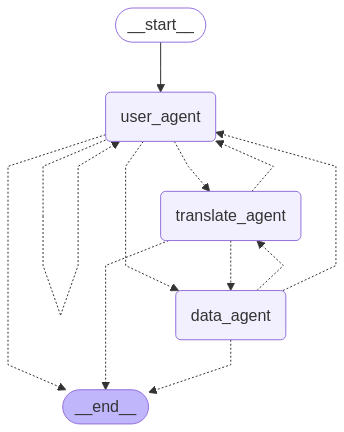

In [14]:
Image(wb_main_graph.get_graph().draw_mermaid_png())

## The finale step: Running the whole system!
After running the following cell you'll be able to interact with the system with free text. You can ask questions and follow-up questions, ask for data about countries and organizations known to the World Bank, specify farther manipulations on the data (if supported) and decide how you want the data to be presented to you: As a text, table, graphs or something else.

Enjoy!

In [1]:
# Run the whole system:

def start():
    """Invoking the system."""
    
    config = {"recursion_limit": 50}
    initial_state = copy.deepcopy(default_state)

    display(Markdown('#### Starting program...'))
    state = wb_main_graph.invoke(initial_state, config)
    display(Markdown('#### ... Program ended.'))
    
    return state

## Simulation run:
We simulate a usecase run with several query lines, as if entered by a user.

#### Starting program...

Welcome to The World Bank geopolitical research tool. At any moment, type "exit", "quit" or simply "q" to quit. 
What would you like to explore today?


>: Hi, what can you do?


I can help you explore data from the World Bank. You can ask me to:

1.  **Get economical information** for specific countries, indicators (like population or GDP), and time ranges. I can also perform additional analysis like normalizing data or finding the top countries based on a specific indicator.
2.  **Translate names and codes** used by the World Bank for countries and indicators.
3.  **Perform operations and analysis** on data I've already provided to you, such as plotting graphs or creating tables.

How can I help you today?



>: What are the WB codes for "The Aussie State" and "government military budget"? answer in simple text.


Here are the World Bank codes for your requests:

*   **The Aussie State:** AUS
*   **government military budget:** MS.MIL.XPND.CD, MS.MIL.XPND.CN, MS.MIL.XPND.GD.ZS, MS.MIL.XPND.ZS



>: What are the top 5 members of the OECD in terms of GDP per capita PPP in 2022? Show it in a table.


,index,LUX,IRL,NOR,CHE,USA
0,Country,Luxembourg,Ireland,Norway,Switzerland,United States
1,NY.GDP.PCAP.PP.KD,134629.225269,125625.319755,90838.907955,82203.059276,72841.924313



>: Plot in a multi line graph the percentage of income held by the wealthiest 10%, of Norway, Switzerland, United States, Luxembourg and Ireland, in the years 2010-2022.


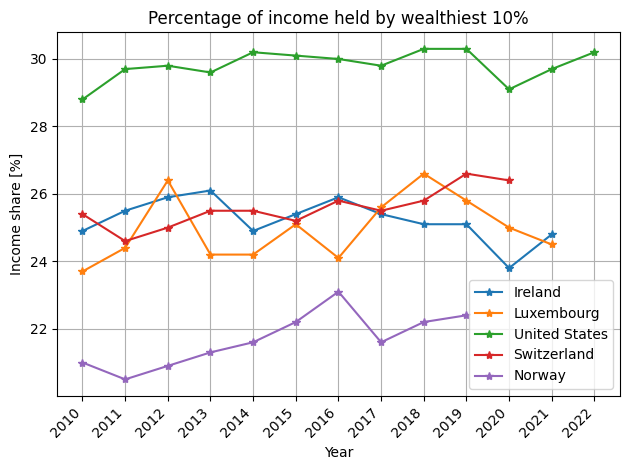


>: Plot in a bar graph the birth rate, baby mortality rate and total mortality rate of Singapore in 2010-2015.


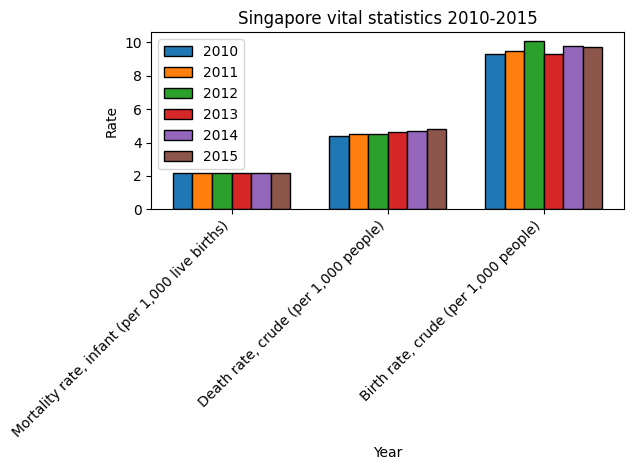


>: exit


#### ... Program ended.

In [39]:
# Simulating a run:

from unittest.mock import patch

# The inputs our mock user would've entered:
mock_inputs = ('Hi, what can you do?',
               'What are the WB codes for "The Aussie State" and "government military budget"? answer in simple text.',
               'What are the top 5 members of the OECD in terms of GDP per capita PPP in 2022? Show it in a table.',
               'Plot in a multi line graph the percentage of income held by the wealthiest 10%, of Norway, Switzerland, ' +\
                   'United States, Luxembourg and Ireland, in the years 2010-2022.',
               'Plot in a bar graph the birth rate, baby mortality rate and total mortality rate of Singapore in 2010-2015.',
               'exit'
               )
mock_input_iter = iter(mock_inputs)

# Custom input mock that prints the input text like a user would type
def mock_input_wrap_func(prompt):
    response = next(mock_input_iter)
    print(f"{prompt}{response}")
    return response

# Run the simulation:
with patch('builtins.input', side_effect=mock_input_wrap_func):#mock_inputs):
    start()


#
## Now it's your turn:
You can interact with the system with free text. You can ask questions and follow-up questions, ask for data about countries and organizations known to the World Bank, specify farther manipulations on the data (if supported) and decide how you want the data to be presented to you: As a text, table, graphs or something else.

Enjoy!

In [ ]:
final_state = start()